In [1]:
import matplotlib.pyplot as plt
from exp_utils import *

In [2]:
print('HYPERPARAMETER_SETTINGS')
for k, v in CONF.__dict__.items():
    if k.isupper():
        print(k, '=', v)

HYPERPARAMETER_SETTINGS
TRAIN_DATA_SIZE = 100000
DEV_DATA_SIZE = 5000
NUM_SIN_PARAMS = 4
DIM_INPUT = 100
DIM_HIDDEN_BOTTOM = 16
DIM_HIDDEN_TOWER = 8
NUM_EXPERT = 8
NUM_TASK = 2
MAX_STEP = 500000
BATCH_SIZE = 32
LR = 0.0005
NUM_PROCESS = 4


In [3]:
num_params = CONF.DIM_INPUT * CONF.DIM_HIDDEN_BOTTOM * CONF.NUM_EXPERT + \
             CONF.DIM_HIDDEN_BOTTOM * CONF.DIM_HIDDEN_TOWER * CONF.NUM_TASK

dim_hidden_bottom = int(num_params / (CONF.DIM_INPUT + CONF.NUM_TASK * CONF.DIM_HIDDEN_TOWER))

model = VanillaSharedBottomRegressor(CONF.NUM_TASK, CONF.DIM_INPUT, dim_hidden_bottom, CONF.DIM_HIDDEN_TOWER)

base_df_corr_0_5 = exp_mp(model, task_corr=0.5, N=5)
base_df_corr_0_9 = exp_mp(model, task_corr=0.9, N=5)
base_df_corr_1_0 = exp_mp(model, task_corr=1.0, N=5)

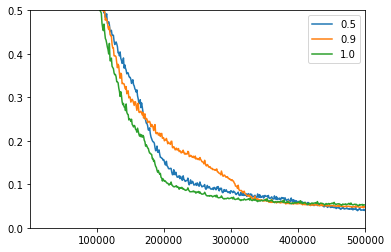

In [4]:
base_df_corr_0_5.mean().plot(label='0.5')
base_df_corr_0_9.mean().plot(label='0.9')
base_df_corr_1_0.mean().plot(label='1.0')
plt.ylim(0, 0.5)
plt.legend()

In [5]:
model = MMoERegressor(CONF.NUM_EXPERT, CONF.NUM_TASK, CONF.DIM_INPUT, CONF.DIM_HIDDEN_BOTTOM, CONF.DIM_HIDDEN_TOWER)

mmoe_df_corr_0_5 = exp_mp(model, task_corr=0.5, N=5)
# mmoe_df_corr_0_9 = exp_mp(model, task_corr=0.9, N=10)
# mmoe_df_corr_1_0 = exp_mp(model, task_corr=1.0, N=10)

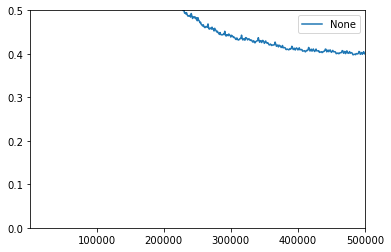

In [9]:
mmoe_df_corr_0_5.mean().plot()
plt.ylim(0, 0.5)
plt.legend()

In [6]:
model = MoERegressor(CONF.NUM_EXPERT, CONF.NUM_TASK, CONF.DIM_INPUT, CONF.DIM_HIDDEN_BOTTOM, CONF.DIM_HIDDEN_TOWER)

omoe_corr_0_5 = exp_mp(model, task_corr=0.5, N=5)
# omoe_corr_0_9 = exp_mp(model, task_corr=0.9, N=10)
# omoe_corr_1_0 = exp_mp(model, task_corr=1.0, N=10)

Process ForkPoolWorker-19:
Process ForkPoolWorker-18:
Traceback (most recent call last):


KeyboardInterrupt: 